In [25]:
from autoencoder.unet import UNet
from clickref.model import Click_ref
import torch
from autoencoder.dataloader import * 
import matplotlib.pyplot as plt
from tqdm import tqdm
from create_gt_grids import Gtgrid
from sklearn.metrics import pairwise_distances
from utils import *
from find_same_nucleis import FindSame2
from grids_to_clicks import Grid_to_click
from clickref.metrics import model_predict_with_click
import numpy as np
import tifffile
from config import *
from skimage.morphology import (
    area_opening,
    binary_opening,
    binary_closing,
    binary_dilation,
)
from skimage.morphology import disk
from skimage.measure import label
from matching import matching
from glob import glob

## autoencoder

In [2]:
def display_four_images(img1, img2, img3, img4):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    axs[0].imshow(img1)
    axs[0].set_title('click')
    axs[0].axis('off')

    axs[1].imshow(img2)
    axs[1].set_title('image')
    axs[1].axis('off')

    axs[2].imshow(img3)
    axs[2].set_title('baseline')
    axs[2].axis('off')

    axs[3].imshow(img4)
    axs[3].set_title('gt')
    axs[3].axis('off')

    plt.show()

In [3]:
from clickref.dataloader import dataloaders
import sys
sys.path.append('/home/ahabis/1-Click_project/clickref')
# from metrics import n_channel_to_rgb
# x = next(iter(dataloaders['train']))
# import matplotlib.pyplot as plt
# image_and_click, baseline, gt, click = x
# image = image_and_click.cpu().detach().numpy()[0][:3,...].T
# click = n_channel_to_rgb(image_and_click.cpu().detach().numpy()[0][3:,...].T)
# gt = gt.cpu().detach().numpy()[0].T
# baseline = baseline.cpu().detach().numpy()[0].T
# display_four_images(click, image, baseline, gt)


In [4]:
import numpy as np
# plt.imshow(np.max(image_and_click.cpu().detach().numpy()[0][3:,...].T,axis = -1)>0.5)

In [26]:
autoencoder = UNet(3, 3)
device = torch.device('cpu')
autoencoder.to('cpu')
autoencoder.load_state_dict(torch.load(os.path.join(path_pannuke,"weights_autoencoder_CAE_"+str(parameters['n_embedding'])), map_location=device))
click_ref = Click_ref(3, 3)
click_ref.load_state_dict(
    torch.load(path_weights_click_ref, map_location=device)
)
click_ref

Click_ref(
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (sigmoid): Sigmoid()
  (conv_image1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_image2): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_image3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_image4): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_mask1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_mask2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_mask3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_mask4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_mask5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_mask6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_click1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_cli

In [19]:
model =click_ref
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))


model size: 5.572MB


In [22]:
filename = os.listdir(path_images)[70]
image_input = tifffile.imread(os.path.join(path_images,filename))/255
image = torch.tensor(np.transpose(image_input,(-1,0,1))[None]).float()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


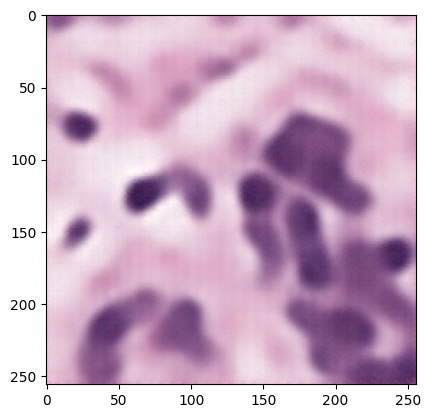

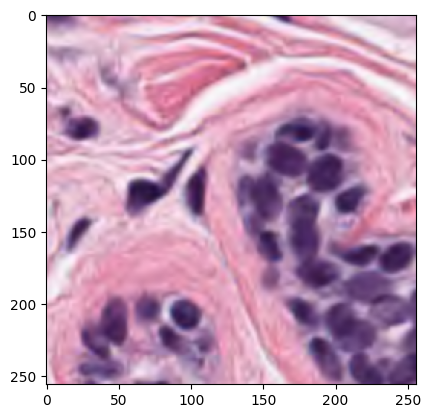

In [23]:
img = np.transpose(autoencoder(image)[0].cpu().detach().numpy()[0],(1,2,0))
plt.imshow(img)
plt.show()
plt.imshow(image_input)
plt.show()

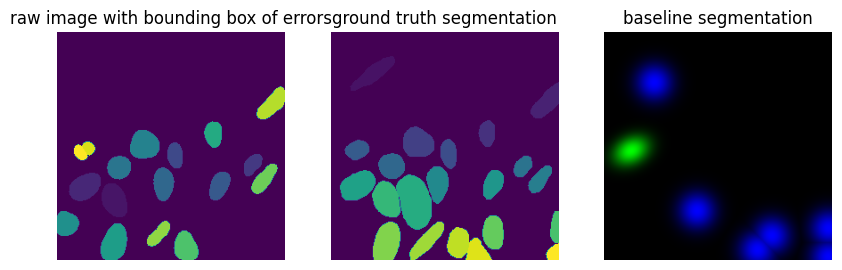

In [20]:
filename = os.listdir(os.path.join(path_stardist_modified,'baseline'))[9]
img_baseline = tifffile.imread(os.path.join(path_stardist_modified,'baseline',filename))
img_gt = tifffile.imread(os.path.join(path_gt,'baseline',filename))
click = tifffile.imread(os.path.join(path_stardist_modified,'click',filename))

fig = plt.figure(figsize=(10, 7))
# setting values to rows and column variables
rows = 1
columns = 3

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(img_baseline)
plt.axis("off")
plt.title("raw image with bounding box of errors")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(img_gt)
plt.axis("off")
plt.title("ground truth segmentation")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(click[:,:,:-1])
plt.axis("off")
plt.title("baseline segmentation")
plt.show()

### choose image support and error localization

In [21]:
f = FindSame2(df_test,
              autoencoder,
              threshold_images=1e-2,
              threshold_nucleis=0.1,
              baseline = path_stardist_modified)

NameError: name 'autoencoder' is not defined

In [19]:
f.extract_errors(90)
f.show_errors_loc()
f.threshold_images = 1e-3
f.select_images_near()
f.threshold_nucleis = 1e-12
(
    images_near,
    images_with_same_errors_detected,
    sub_dataset,
    grids,
    filenames_near,
) = f.find_same_nuclei()

NameError: name 'f' is not defined

##  Click ref

In [31]:
def model_predict_with_click(
    filename,
    model,
    path_baseline,
    click,
    count_erase=15,
    radius=3,
):
    model.eval()
    # model.cuda()

    image_init =tifffile.imread(os.path.join(path_images, filename)) / 255

    contour_baseline = tifffile.imread(
        os.path.join(path_baseline, "contour", filename)
    ).astype(np.float32)
    binary_baseline = tifffile.imread(
        os.path.join(path_baseline, "binary", filename)
    ).astype(np.float32)

    inside_baseline = ((binary_baseline - contour_baseline) > 0).astype(np.float32)
    background_baseline = 1 - np.maximum(contour_baseline, inside_baseline)
    baseline = np.stack(
        (background_baseline, contour_baseline, inside_baseline), axis=-1
    )

    # image = np.concatenate((image_init, click), axis=-1)
    image_tensor = torch.tensor(
        np.transpose(np.expand_dims(image_init, axis=0), (0, -1, 1, 2)).astype(np.float32)
    ) #.cuda()
    click_tensor = torch.tensor(
        np.transpose(np.expand_dims(click, axis=0)
        , (0, -1, 1, 2)).astype(np.float32)
    )
    #.cuda
    baseline_tensor = torch.tensor(
        np.transpose(np.expand_dims(baseline, axis=0), (0, -1, 1, 2)).astype(np.float32)
    ) #.cuda()
    print(image_tensor.dtype, click_tensor.dtype, baseline_tensor.dtype)
    img = model(image_tensor,click_tensor, baseline_tensor)[0]

    out = np.transpose(img.cpu().detach().numpy(), (1, -1, 0))
    plt.imshow(out)
    plt.show()
    arg = np.argmax(out, -1)

    binary = (arg == 2.0).astype(int)
    labels = label(binary)

    _, count = np.unique(labels, return_counts=True)
    indx = np.argwhere(count < count_erase).flatten()
    for i in indx:
        labels[labels == i] = 0.0

    black = np.zeros(labels.shape)

    for i, nuclei in enumerate(np.unique(labels)[1:]):
        black = np.maximum(
            black, (i + 1) * binary_dilation(labels == nuclei, disk(radius)).astype(int)
        )

    return (
        black.astype(int),
        out,
        binary_baseline,
    )

In [32]:
index  = 0
filename = glob(path_images+'/*')[index].split('/')[-1]

torch.float32 torch.float32 torch.float32


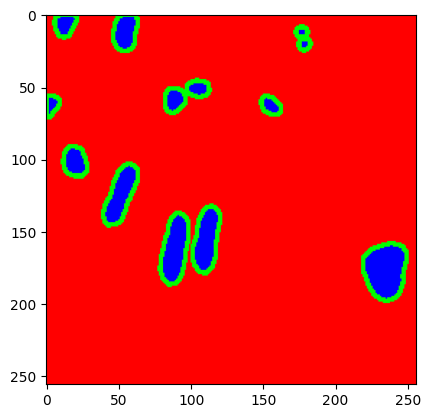

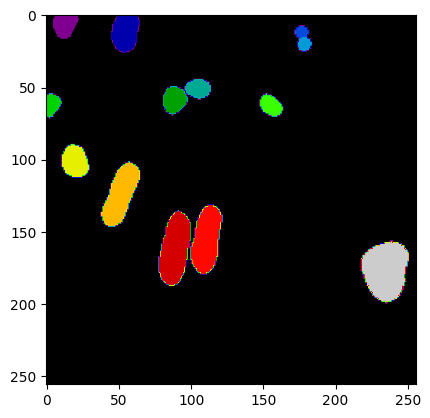

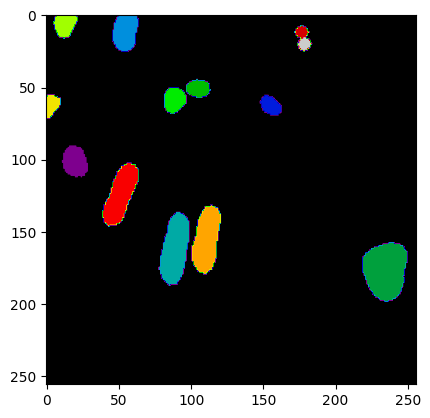

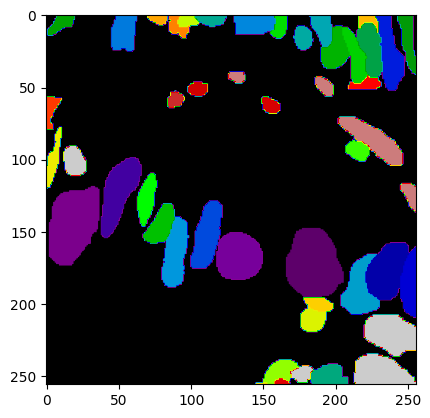

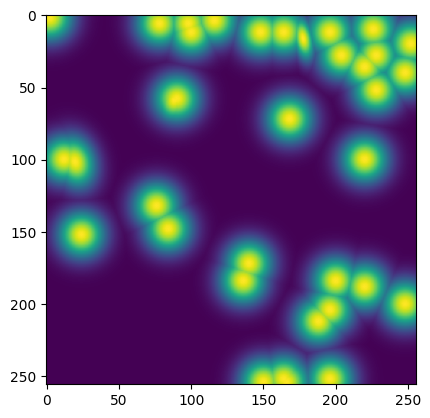

In [33]:
index = 0
click = tifffile.imread(os.path.join(path_stardist_modified,'click',filename))

bef, out, baseline = model_predict_with_click(
    filename,
    click_ref,
    path_stardist_modified,
    click,
    count_erase=5,
    radius=3,
)

baseline = tifffile.imread(os.path.join(path_stardist_modified,'baseline', filename))
gt = tifffile.imread(os.path.join(path_gt,'baseline',filename))
# print(out)
plt.imshow(bef, cmap ='nipy_spectral')
plt.show()
plt.imshow(baseline, cmap ='nipy_spectral')
plt.show()
plt.imshow(gt, cmap ='nipy_spectral')
plt.show()
plt.imshow(np.amax(click,-1))

In [18]:
index = 0

filename = filenames_near[index]
grid = grids[index]
path_baseline = path_stardist_modified
g = Grid_to_click(grid, filename, path_baseline)
click = g.final_click()

bef, out, baseline = model_predict_with_click(
    filename,
    click_ref,
    path_baseline,
    click,
    count_erase=5,
    radius=3,
)

baseline = tifffile.imread(os.path.join(path_baseline,'baseline', filename))
gt = tifffile.imread(os.path.join(path_gt,'baseline',filename))
# print(out)
plt.imshow(bef, cmap ='nipy_spectral')
plt.show()
plt.imshow(baseline, cmap ='nipy_spectral')
plt.show()
plt.imshow(gt, cmap ='nipy_spectral')
plt.show()
plt.imshow(np.amax(click,-1))

NameError: name 'click_ref' is not defined

In [ ]:
precisions, recalls, f1s, AJIs, DICEs, Pans = (
    np.zeros(2),
    np.zeros(2),
    np.zeros(2),
    np.zeros(2),
    np.zeros(2),
    np.zeros(2),
)
index = 1000
n = len(dataset_test.dataframe.filename)
n = index
for filename in tqdm(dataset_test.dataframe.filename[:index]):
    img_baseline = tifffile.imread(os.path.join(path_stardist, "baseline", filename))
    manual_click = tifffile.imread(os.path.join(path_stardist, "click", filename))
    gt = tifffile.imread(os.path.join(path_gt, "baseline", filename))

    bef, out, baseline = model_predict_with_click(
        filename,
        click_ref,
        path_stardist,
        manual_click,
        count_erase=5,
        radius=3,
    )

    match1 = matching(gt, bef)
    match2 = matching(gt, img_baseline.astype(int))

    precisions[0] += match1.precision
    precisions[1] += match2.precision

    recalls[0] += match1.recall
    recalls[1] += match2.recall

    f1s[0] += match1.f1
    f1s[1] += match2.f1

    Pans[0] += match1.panoptic_quality
    Pans[1] += match2.panoptic_quality

    AJIs[0] += AJI(bef, gt)
    AJIs[1] += AJI(img_baseline, gt)

    DICEs[0] += DICE(bef, gt)
    DICEs[1] += DICE(img_baseline, gt)


table = BeautifulTable()
table.rows.append(
    [
        "clickref",
        AJIs[0] / n,
        DICEs[0] / n,
        precisions[0] / n,
        recalls[0] / n,
        f1s[0] / n,
        Pans[0] / n,
    ]
)
table.rows.append(
    [
        "baseline",
        AJIs[1] / n,
        DICEs[1] / n,
        precisions[1] / n,
        recalls[1] / n,
        f1s[1] / n,
        Pans[1] / n,
    ]
)
table.columns.header = [
    "model",
    "AJI",
    "ADICE",
    "Precision",
    "Recall",
    "F1",
    "PANOPTIC",
]

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

[[[9.8324686e-01 1.6390769e-02 3.6244679e-04]
  [9.9970442e-01 2.9456874e-04 1.0010733e-06]
  [9.9998009e-01 1.9848048e-05 1.3249627e-08]
  ...
  [1.0000000e+00 1.3204796e-17 1.9378229e-20]
  [1.0000000e+00 4.9337287e-17 4.0277864e-19]
  [1.0000000e+00 6.0153603e-19 3.9153526e-15]]

 [[9.9991357e-01 7.0642811e-05 1.5759038e-05]
  [9.9999881e-01 1.1511482e-06 2.9146792e-08]
  [9.9999988e-01 8.2616744e-08 6.2840858e-11]
  ...
  [1.0000000e+00 3.1834786e-22 4.3674190e-27]
  [1.0000000e+00 5.2474477e-22 1.3408339e-25]
  [1.0000000e+00 3.6462700e-23 3.8467455e-18]]

 [[9.9999893e-01 4.3368033e-07 5.3861783e-07]
  [9.9999988e-01 1.6221392e-07 6.2901480e-09]
  [1.0000000e+00 9.4232844e-10 2.2373407e-12]
  ...
  [1.0000000e+00 4.6419186e-26 1.0449685e-31]
  [1.0000000e+00 6.1468227e-26 2.2782903e-30]
  [1.0000000e+00 4.7618676e-27 2.9985307e-21]]

 ...

 [[1.0000000e+00 1.3013909e-26 3.8869482e-22]
  [1.0000000e+00 7.8290543e-31 9.2329053e-24]
  [1.0000000e+00 6.8767375e-34 7.7621016e-27]
  ..

  0%|                                          | 2/1000 [00:01<11:25,  1.45it/s]

[[[2.2164151e-01 7.5708723e-01 2.1271266e-02]
  [1.3649108e-01 8.6039901e-01 3.1099359e-03]
  [1.7318170e-01 8.2600749e-01 8.1087847e-04]
  ...
  [1.0000000e+00 5.0232352e-16 1.4629144e-18]
  [1.0000000e+00 1.5604243e-15 2.0262663e-17]
  [1.0000000e+00 2.4315240e-17 7.3901870e-14]]

 [[1.0507447e-01 8.9256519e-01 2.3603223e-03]
  [4.4489395e-02 9.5539957e-01 1.1103817e-04]
  [5.4180153e-02 9.4579995e-01 1.9932761e-05]
  ...
  [1.0000000e+00 4.6373312e-20 1.5734837e-24]
  [1.0000000e+00 6.4739329e-20 2.9404636e-23]
  [1.0000000e+00 4.6060349e-21 1.5667698e-16]]

 [[9.9035129e-02 9.0041083e-01 5.5409671e-04]
  [4.1060310e-02 9.5892274e-01 1.6913838e-05]
  [8.7739646e-02 9.1225636e-01 3.8878834e-06]
  ...
  [1.0000000e+00 2.3951441e-23 1.5522034e-28]
  [1.0000000e+00 2.2877302e-23 1.8954122e-27]
  [1.0000000e+00 1.9802799e-24 3.0813504e-19]]

 ...

 [[1.0000000e+00 3.6119454e-26 5.5641866e-22]
  [1.0000000e+00 8.1684984e-29 9.1550154e-23]
  [1.0000000e+00 2.5439249e-30 1.4037467e-24]
  ..

  0%|▏                                         | 4/1000 [00:02<10:49,  1.53it/s]

[[[9.8938262e-01 1.0495795e-02 1.2159265e-04]
  [9.9988496e-01 1.1493907e-04 1.3938239e-07]
  [9.9999499e-01 5.0633093e-06 8.6217716e-10]
  ...
  [1.0000000e+00 2.4296092e-21 6.0743789e-25]
  [1.0000000e+00 9.2519231e-21 2.0155368e-23]
  [1.0000000e+00 3.4440115e-23 1.5322208e-18]]

 [[9.9997485e-01 2.2087697e-05 3.1115198e-06]
  [9.9999976e-01 1.9136559e-07 1.8363877e-09]
  [1.0000000e+00 9.6317727e-09 1.4364524e-12]
  ...
  [1.0000000e+00 1.6763501e-26 9.6248963e-33]
  [1.0000000e+00 1.9933746e-26 4.5559636e-31]
  [1.0000000e+00 6.2981549e-28 5.8411245e-22]]

 [[9.9999988e-01 6.5392996e-08 5.8545503e-08]
  [1.0000000e+00 1.6750807e-08 2.4426142e-10]
  [1.0000000e+00 4.3196526e-11 1.9448642e-14]
  ...
  [1.0000000e+00 1.5188848e-30 9.6722418e-38]
  [1.0000000e+00 1.0163757e-30 2.8315865e-36]
  [1.0000000e+00 3.8559444e-32 2.4694374e-25]]

 ...

 [[1.0000000e+00 4.7884818e-34 3.3213009e-28]
  [1.0000000e+00 4.9291206e-39 5.6638733e-30]
  [1.0000000e+00 1.4909816e-42 1.2313572e-33]
  ..

  1%|▎                                         | 6/1000 [00:04<10:46,  1.54it/s]

[[[9.8502570e-01 1.4749052e-02 2.2517161e-04]
  [9.9977702e-01 2.2259001e-04 4.0250276e-07]
  [9.9998820e-01 1.1801424e-05 3.2874492e-09]
  ...
  [1.0000000e+00 1.6274225e-19 1.1260044e-22]
  [1.0000000e+00 6.8612512e-19 3.3767187e-21]
  [1.0000000e+00 5.0053159e-21 9.3936185e-17]]

 [[9.9994504e-01 4.7826259e-05 7.1631066e-06]
  [9.9999940e-01 5.5029420e-07 6.4514816e-09]
  [1.0000000e+00 3.4135617e-08 7.7881417e-12]
  ...
  [1.0000000e+00 7.2129803e-25 3.4668289e-30]
  [1.0000000e+00 1.1545408e-24 1.5863115e-28]
  [1.0000000e+00 6.4822414e-26 3.3008274e-20]]

 [[9.9999964e-01 2.1135986e-07 1.7085198e-07]
  [1.0000000e+00 5.0951055e-08 8.8649105e-10]
  [1.0000000e+00 1.9278790e-10 1.1846981e-13]
  ...
  [1.0000000e+00 2.6937672e-29 1.6204774e-35]
  [1.0000000e+00 3.5035642e-29 5.4326890e-34]
  [1.0000000e+00 2.3239525e-30 9.2042444e-24]]

 ...

 [[1.0000000e+00 1.0754467e-20 3.1991667e-17]
  [1.0000000e+00 1.3402573e-23 2.4943939e-18]
  [1.0000000e+00 6.6781698e-26 1.1423815e-20]
  ..

  1%|▎                                         | 7/1000 [00:04<10:12,  1.62it/s]

[[[9.85959113e-01 1.38097778e-02 2.31021579e-04]
  [9.99803483e-01 1.96093926e-04 4.37772115e-07]
  [9.99989867e-01 1.01011374e-05 3.97283140e-09]
  ...
  [1.00000000e+00 5.58478786e-16 2.89264233e-18]
  [1.00000000e+00 3.62084986e-15 6.89823632e-17]
  [1.00000000e+00 1.25434740e-16 2.61083039e-13]]

 [[9.99947906e-01 4.41697193e-05 7.89034311e-06]
  [9.99999523e-01 5.24014865e-07 8.77815864e-09]
  [1.00000000e+00 2.74242389e-08 1.16829385e-11]
  ...
  [1.00000000e+00 3.83824018e-20 3.94415030e-24]
  [1.00000000e+00 1.93275209e-19 1.64061586e-22]
  [1.00000000e+00 3.78147330e-20 7.43667187e-16]]

 [[9.99999523e-01 1.88289491e-07 1.98464832e-07]
  [1.00000000e+00 5.59272024e-08 1.43647105e-09]
  [1.00000000e+00 1.98943695e-10 2.53040671e-13]
  ...
  [1.00000000e+00 1.78633434e-23 4.05001593e-28]
  [1.00000000e+00 9.25494959e-23 1.67107626e-26]
  [1.00000000e+00 2.10110199e-23 1.94684216e-18]]

 ...

 [[1.00000000e+00 7.74154600e-28 5.04663004e-23]
  [1.00000000e+00 5.06572120e-32 1.4430

  1%|▎                                         | 8/1000 [00:05<09:45,  1.69it/s]

[[[9.8260629e-01 1.7061854e-02 3.3189886e-04]
  [9.9969149e-01 3.0770851e-04 8.1965140e-07]
  [9.9998093e-01 1.9088900e-05 8.8157481e-09]
  ...
  [1.0000000e+00 2.1710073e-17 2.6152168e-20]
  [1.0000000e+00 7.4894223e-17 5.1444105e-19]
  [1.0000000e+00 9.2325392e-19 4.7207840e-15]]

 [[9.9991488e-01 7.2065333e-05 1.2998924e-05]
  [9.9999893e-01 1.0761796e-06 1.8642389e-08]
  [9.9999988e-01 7.2378484e-08 3.1387230e-11]
  ...
  [1.0000000e+00 1.4223398e-21 1.5756386e-26]
  [1.0000000e+00 2.1463729e-21 4.0737758e-25]
  [1.0000000e+00 1.6038891e-22 9.3151861e-18]]

 [[9.9999928e-01 4.0744160e-07 3.9197104e-07]
  [9.9999988e-01 1.3000549e-07 3.3243874e-09]
  [1.0000000e+00 6.5812239e-10 7.9345997e-13]
  ...
  [1.0000000e+00 1.1561362e-24 2.1699001e-30]
  [1.0000000e+00 1.0606187e-24 3.6950284e-29]
  [1.0000000e+00 9.2381103e-26 2.2949099e-20]]

 ...

 [[1.0000000e+00 6.8138288e-35 6.0932806e-29]
  [1.0000000e+00 4.7952994e-40 8.6853676e-31]
  [1.0000000e+00 1.1350518e-43 1.5606414e-34]
  ..

  1%|▍                                         | 9/1000 [00:05<09:56,  1.66it/s]

[[[9.7957557e-01 1.9878114e-02 5.4643629e-04]
  [9.9957639e-01 4.2152355e-04 2.0875796e-06]
  [9.9996829e-01 3.1739924e-05 3.2869593e-08]
  ...
  [1.0000000e+00 1.4823436e-13 8.7820170e-16]
  [1.0000000e+00 3.4456910e-13 6.0842190e-15]
  [1.0000000e+00 5.8931013e-15 5.0145227e-12]]

 [[9.9987376e-01 9.9606194e-05 2.6561616e-05]
  [9.9999797e-01 1.9094059e-06 6.9306047e-08]
  [9.9999988e-01 1.4818237e-07 2.0493920e-10]
  ...
  [1.0000000e+00 5.3953156e-16 3.9854179e-20]
  [1.0000000e+00 3.6131630e-16 2.0884884e-19]
  [1.0000000e+00 1.6395939e-17 6.6913943e-14]]

 [[9.9999821e-01 7.4560370e-07 1.0484298e-06]
  [9.9999976e-01 2.7224431e-07 1.4908535e-08]
  [1.0000000e+00 1.9035742e-09 7.8365708e-12]
  ...
  [1.0000000e+00 1.4447800e-17 2.0978754e-22]
  [1.0000000e+00 6.2697569e-18 5.9911732e-22]
  [1.0000000e+00 2.5321177e-19 1.6955765e-15]]

 ...

 [[1.0000000e+00 3.8913680e-15 2.6824376e-13]
  [1.0000000e+00 2.8618417e-20 1.9491700e-16]
  [1.0000000e+00 3.8714654e-24 7.9573961e-20]
  ..

  1%|▍                                        | 10/1000 [00:06<10:43,  1.54it/s]

[[[7.42315531e-01 2.39556059e-01 1.81284323e-02]
  [9.34226155e-01 6.40580505e-02 1.71583123e-03]
  [9.75085258e-01 2.45918650e-02 3.22795939e-04]
  ...
  [9.99999881e-01 9.14796203e-08 2.59476018e-09]
  [9.99999881e-01 1.40036590e-07 8.55406768e-09]
  [9.99999523e-01 1.40420671e-08 4.46184714e-07]]

 [[9.41312373e-01 5.01466803e-02 8.54092743e-03]
  [9.60547686e-01 3.79793830e-02 1.47288456e-03]
  [9.85567212e-01 1.43031767e-02 1.29584441e-04]
  ...
  [1.00000000e+00 2.82038659e-09 1.22757195e-11]
  [1.00000000e+00 2.06914574e-09 2.62484340e-11]
  [1.00000000e+00 3.36293882e-10 3.91092279e-08]]

 [[9.90531504e-01 6.16356032e-03 3.30491364e-03]
  [9.83596325e-01 1.48984753e-02 1.50521216e-03]
  [9.96238232e-01 3.65113374e-03 1.10517452e-04]
  ...
  [1.00000000e+00 1.64787670e-10 4.18184611e-13]
  [1.00000000e+00 9.83564202e-11 6.21387815e-13]
  [1.00000000e+00 1.13298173e-11 2.87837221e-09]]

 ...

 [[1.00000000e+00 3.30177455e-26 7.69117522e-22]
  [1.00000000e+00 2.98242063e-30 2.1898

  1%|▍                                        | 11/1000 [00:07<10:43,  1.54it/s]

[[[9.83080149e-01 1.66097563e-02 3.10105039e-04]
  [9.99719918e-01 2.79405154e-04 7.24375184e-07]
  [9.99982595e-01 1.74400775e-05 7.11773929e-09]
  ...
  [1.00000000e+00 5.27661663e-21 1.77806625e-24]
  [1.00000000e+00 1.97924174e-20 5.69346285e-23]
  [1.00000000e+00 7.70418031e-23 3.19687150e-18]]

 [[9.99924779e-01 6.32521987e-05 1.18608341e-05]
  [9.99999166e-01 8.51339735e-07 1.66187863e-08]
  [1.00000000e+00 4.85917866e-08 2.39985028e-11]
  ...
  [1.00000000e+00 1.33371188e-26 1.75358058e-32]
  [1.00000000e+00 1.97037656e-26 7.96412281e-31]
  [1.00000000e+00 7.55875166e-28 8.21847357e-22]]

 [[9.99999285e-01 3.00184013e-07 3.21216760e-07]
  [9.99999881e-01 9.30383237e-08 2.71171330e-09]
  [1.00000000e+00 3.96867345e-10 5.88341713e-13]
  ...
  [1.00000000e+00 4.69933019e-31 5.98062077e-38]
  [1.00000000e+00 5.43873118e-31 2.24683254e-36]
  [1.00000000e+00 2.70392442e-32 2.07448355e-25]]

 ...

 [[1.00000000e+00 2.01575778e-25 3.81734280e-21]
  [1.00000000e+00 3.13090998e-29 1.6208

  1%|▍                                        | 12/1000 [00:07<10:21,  1.59it/s]

[[[9.89344537e-01 1.05427019e-02 1.12794398e-04]
  [9.99886751e-01 1.13152986e-04 1.20366948e-07]
  [9.99995112e-01 4.93276275e-06 6.79371559e-10]
  ...
  [1.00000000e+00 5.34855249e-16 1.15833823e-18]
  [1.00000000e+00 1.55653612e-15 1.54768884e-17]
  [1.00000000e+00 2.01537974e-17 5.86958935e-14]]

 [[9.99975085e-01 2.20207330e-05 2.84321072e-06]
  [9.99999762e-01 1.90667876e-07 1.60155178e-09]
  [1.00000000e+00 8.97507668e-09 1.09073601e-12]
  ...
  [1.00000000e+00 3.05351170e-20 8.90208627e-25]
  [1.00000000e+00 4.36353800e-20 1.51975962e-23]
  [1.00000000e+00 2.80156683e-21 9.82087785e-17]]

 [[1.00000000e+00 5.81248187e-08 4.95309926e-08]
  [1.00000000e+00 1.64607190e-08 2.17966589e-10]
  [1.00000000e+00 3.85516202e-11 1.50632409e-14]
  ...
  [1.00000000e+00 7.99321832e-24 4.29098696e-29]
  [1.00000000e+00 1.00027444e-23 5.94952260e-28]
  [1.00000000e+00 6.88879392e-25 1.28523330e-19]]

 ...

 [[1.00000000e+00 6.16484420e-30 7.51027629e-25]
  [1.00000000e+00 4.41492582e-34 2.9764

  1%|▌                                        | 13/1000 [00:08<10:01,  1.64it/s]

[[[9.6946162e-01 2.9941441e-02 5.9687957e-04]
  [9.9925202e-01 7.4595714e-04 1.9737095e-06]
  [9.9995041e-01 4.9593509e-05 2.1382395e-08]
  ...
  [1.0000000e+00 1.1863745e-15 5.8664803e-18]
  [1.0000000e+00 6.0655220e-15 1.4422377e-16]
  [1.0000000e+00 2.4317167e-16 5.4921887e-13]]

 [[9.9977475e-01 2.0081039e-04 2.4410971e-05]
  [9.9999666e-01 3.2948583e-06 3.2611549e-08]
  [9.9999964e-01 3.4707520e-07 7.8970247e-11]
  ...
  [1.0000000e+00 1.1248422e-20 2.1922042e-24]
  [1.0000000e+00 3.6170308e-20 9.9987438e-23]
  [1.0000000e+00 8.7082651e-21 4.9016129e-16]]

 [[9.9999726e-01 1.9522479e-06 8.1275158e-07]
  [9.9999964e-01 2.9837602e-07 3.4996583e-09]
  [1.0000000e+00 1.8284647e-09 7.0702206e-13]
  ...
  [1.0000000e+00 2.8839167e-25 1.0627787e-29]
  [1.0000000e+00 1.2818270e-24 6.5049748e-28]
  [1.0000000e+00 3.7702988e-25 1.8692746e-19]]

 ...

 [[1.0000000e+00 3.4124830e-22 1.5614401e-18]
  [1.0000000e+00 2.2554241e-25 1.1198805e-19]
  [1.0000000e+00 1.1305984e-27 4.5492288e-22]
  ..

  1%|▌                                        | 14/1000 [00:09<10:30,  1.56it/s]

[[[9.80042815e-01 1.96564831e-02 3.00768064e-04]
  [9.99683619e-01 3.15799611e-04 6.12096869e-07]
  [9.99984264e-01 1.56824281e-05 5.06774933e-09]
  ...
  [1.00000000e+00 1.43523027e-10 3.01494138e-12]
  [1.00000000e+00 3.10043741e-10 1.69310503e-11]
  [1.00000000e+00 2.03807353e-11 3.58612207e-09]]

 [[9.99917269e-01 7.32363333e-05 9.49055993e-06]
  [9.99999166e-01 8.04186357e-07 8.76737971e-09]
  [1.00000000e+00 4.71565542e-08 1.22255296e-11]
  ...
  [1.00000000e+00 2.31702813e-13 2.98581152e-16]
  [1.00000000e+00 2.75893268e-13 1.98544735e-15]
  [1.00000000e+00 4.17389884e-14 4.60137761e-11]]

 [[9.99999404e-01 3.70735819e-07 2.32106757e-07]
  [9.99999881e-01 6.49227303e-08 1.04857389e-09]
  [1.00000000e+00 2.11762746e-10 1.44514676e-13]
  ...
  [1.00000000e+00 7.22631548e-16 3.04502167e-19]
  [1.00000000e+00 7.41630285e-16 1.56021949e-18]
  [1.00000000e+00 1.09309999e-16 4.23541329e-13]]

 ...

 [[1.00000000e+00 4.13573369e-33 1.77546763e-27]
  [1.00000000e+00 1.02582559e-37 5.1808

  2%|▌                                        | 15/1000 [00:09<10:05,  1.63it/s]

[[[9.75327015e-01 2.35313177e-02 1.14160613e-03]
  [9.99232411e-01 7.59092858e-04 8.48816217e-06]
  [9.99928117e-01 7.16186769e-05 2.49717488e-07]
  ...
  [1.00000000e+00 1.19897281e-15 2.71632899e-18]
  [1.00000000e+00 2.59991490e-15 2.33028839e-17]
  [1.00000000e+00 2.04963527e-17 5.88893693e-14]]

 [[9.99777734e-01 1.50110442e-04 7.21830293e-05]
  [9.99996305e-01 3.29897262e-06 2.99758597e-07]
  [9.99999523e-01 5.01507088e-07 2.46574783e-09]
  ...
  [1.00000000e+00 1.38234042e-19 2.98748527e-24]
  [1.00000000e+00 1.18039552e-19 2.44402424e-23]
  [1.00000000e+00 3.43602304e-21 1.00999401e-16]]

 [[9.99992967e-01 2.58711634e-06 4.43933504e-06]
  [9.99999404e-01 4.42626060e-07 6.10350810e-08]
  [1.00000000e+00 7.79323628e-09 7.82343149e-11]
  ...
  [1.00000000e+00 6.56161564e-23 2.10841084e-28]
  [1.00000000e+00 3.93111414e-23 1.17195562e-27]
  [1.00000000e+00 1.07141520e-24 1.46972094e-19]]

 ...

 [[1.00000000e+00 1.64279646e-28 1.49687714e-23]
  [1.00000000e+00 2.14538681e-32 7.8952

  2%|▋                                        | 16/1000 [00:10<09:39,  1.70it/s]

[[[9.48427081e-01 4.91138771e-02 2.45902897e-03]
  [9.97357905e-01 2.61369068e-03 2.84707075e-05]
  [9.99649048e-01 3.49941838e-04 9.94821448e-07]
  ...
  [9.99998927e-01 1.11971440e-06 4.54730760e-08]
  [9.99998808e-01 1.13028000e-06 1.03529743e-07]
  [9.99997079e-01 1.22103017e-07 2.83324175e-06]]

 [[9.98702288e-01 1.04304380e-03 2.54680694e-04]
  [9.99943018e-01 5.48775897e-05 2.16320768e-06]
  [9.99991536e-01 8.48037234e-06 1.94633802e-08]
  ...
  [1.00000000e+00 1.04468372e-08 1.00175306e-10]
  [1.00000000e+00 5.42283107e-09 1.69531292e-10]
  [9.99999881e-01 1.07196862e-09 1.16901099e-07]]

 [[9.99956250e-01 2.34190120e-05 2.03809705e-05]
  [9.99984145e-01 1.50639607e-05 8.36523270e-07]
  [9.99999642e-01 3.77303877e-07 1.94787564e-09]
  ...
  [1.00000000e+00 1.37691539e-10 4.33978130e-13]
  [1.00000000e+00 6.66473959e-11 8.27776812e-13]
  [1.00000000e+00 1.17504600e-11 3.32704841e-09]]

 ...

 [[1.00000000e+00 1.22098013e-17 7.34424321e-15]
  [1.00000000e+00 1.80190003e-20 5.9657

  2%|▋                                        | 17/1000 [00:10<09:48,  1.67it/s]

[[[9.5860636e-01 3.9917018e-02 1.4766194e-03]
  [9.9851543e-01 1.4738711e-03 1.0738747e-05]
  [9.9987185e-01 1.2784237e-04 2.4407871e-07]
  ...
  [1.0000000e+00 8.2937661e-17 7.0956206e-20]
  [1.0000000e+00 1.3605739e-16 5.9887602e-19]
  [1.0000000e+00 5.8407771e-19 3.1661954e-15]]

 [[9.9944192e-01 4.6566498e-04 9.2434668e-05]
  [9.9998713e-01 1.2519337e-05 3.0946731e-07]
  [9.9999785e-01 2.1151807e-06 2.0818089e-09]
  ...
  [1.0000000e+00 8.4439825e-21 3.5857105e-26]
  [1.0000000e+00 4.0752139e-21 2.7770988e-25]
  [1.0000000e+00 6.9059825e-23 4.2484352e-18]]

 [[9.9998510e-01 9.5782962e-06 5.3309618e-06]
  [9.9999845e-01 1.5274002e-06 4.1039158e-08]
  [1.0000000e+00 2.2957687e-08 3.3925914e-11]
  ...
  [1.0000000e+00 4.3117875e-24 2.4468795e-30]
  [1.0000000e+00 1.1205144e-24 9.8696740e-30]
  [1.0000000e+00 1.7237209e-26 5.0288978e-21]]

 ...

 [[1.0000000e+00 1.5017382e-16 6.8904877e-14]
  [1.0000000e+00 4.0456026e-19 6.6368360e-15]
  [1.0000000e+00 4.6840160e-21 7.0342116e-17]
  ..

  2%|▋                                        | 18/1000 [00:11<09:58,  1.64it/s]

[[[9.13166165e-01 7.44129717e-02 1.24207484e-02]
  [9.90727901e-01 8.64436012e-03 6.27761649e-04]
  [9.97797608e-01 2.12401012e-03 7.84138319e-05]
  ...
  [1.00000000e+00 4.19461151e-13 3.89035880e-15]
  [1.00000000e+00 1.19228065e-12 3.95759678e-14]
  [1.00000000e+00 5.60131538e-14 3.60161796e-11]]

 [[9.94044125e-01 3.33151408e-03 2.62436876e-03]
  [9.99531627e-01 3.43146094e-04 1.25228806e-04]
  [9.99908209e-01 8.47417323e-05 7.07009622e-06]
  ...
  [1.00000000e+00 1.11151912e-16 4.00426825e-20]
  [1.00000000e+00 1.71372447e-16 5.86050640e-19]
  [1.00000000e+00 2.78699184e-17 1.76605475e-13]]

 [[9.99218345e-01 2.48423661e-04 5.33150451e-04]
  [9.99788225e-01 1.39889919e-04 7.19266536e-05]
  [9.99985695e-01 1.24073549e-05 1.91091272e-06]
  ...
  [1.00000000e+00 8.94950486e-20 8.64240036e-24]
  [1.00000000e+00 1.27090924e-19 1.01175324e-22]
  [1.00000000e+00 2.25378654e-20 6.22652649e-16]]

 ...

 [[1.00000000e+00 1.69588908e-20 4.96734366e-17]
  [1.00000000e+00 4.20094748e-23 7.5901

  2%|▊                                        | 19/1000 [00:12<09:58,  1.64it/s]

[[[9.55607593e-01 4.21751328e-02 2.21724249e-03]
  [9.98063862e-01 1.91173539e-03 2.43982649e-05]
  [9.99767721e-01 2.31527680e-04 7.70521581e-07]
  ...
  [9.99977708e-01 2.07496414e-05 1.49726759e-06]
  [9.99975801e-01 2.20736583e-05 2.14556871e-06]
  [9.99972105e-01 1.59107697e-06 2.63170077e-05]]

 [[9.99190629e-01 6.15056488e-04 1.94272929e-04]
  [9.99975324e-01 2.32854127e-05 1.44218086e-06]
  [9.99997020e-01 3.01099863e-06 1.21020856e-08]
  ...
  [9.99999881e-01 1.14503727e-07 2.14428675e-09]
  [9.99999881e-01 6.55658496e-08 3.12626880e-09]
  [9.99999404e-01 5.89050675e-09 6.52715244e-07]]

 [[9.99974728e-01 1.14376544e-05 1.37712450e-05]
  [9.99994874e-01 4.76862442e-06 4.05323760e-07]
  [9.99999881e-01 9.12140905e-08 8.93697782e-10]
  ...
  [1.00000000e+00 3.45119516e-10 1.74528979e-12]
  [1.00000000e+00 2.01154052e-10 3.08143224e-12]
  [1.00000000e+00 1.95657119e-11 7.47402051e-09]]

 ...

 [[1.00000000e+00 1.62495555e-24 2.39954643e-20]
  [1.00000000e+00 2.49337270e-28 8.6713

  2%|▊                                        | 20/1000 [00:12<09:53,  1.65it/s]

[[[5.43540835e-01 2.91912645e-01 1.64546609e-01]
  [6.95357084e-01 2.07965985e-01 9.66769233e-02]
  [7.62495816e-01 1.75962865e-01 6.15412109e-02]
  ...
  [1.00000000e+00 1.26085869e-14 3.06729225e-17]
  [1.00000000e+00 1.68415459e-14 1.74727809e-16]
  [1.00000000e+00 1.49056292e-16 2.92989645e-13]]

 [[6.90633237e-01 1.55048758e-01 1.54317990e-01]
  [7.56180823e-01 1.36079624e-01 1.07739516e-01]
  [8.13301563e-01 1.23157285e-01 6.35410920e-02]
  ...
  [1.00000000e+00 1.68650412e-18 5.08885082e-23]
  [1.00000000e+00 7.88701618e-19 2.91476759e-22]
  [1.00000000e+00 2.39082064e-20 5.35165475e-16]]

 [[7.87828505e-01 8.68394151e-02 1.25332117e-01]
  [7.97027707e-01 1.01092592e-01 1.01879656e-01]
  [8.58342469e-01 7.96124339e-02 6.20450638e-02]
  ...
  [1.00000000e+00 6.71799147e-22 3.16487182e-27]
  [1.00000000e+00 2.19031736e-22 1.23936812e-26]
  [1.00000000e+00 6.15532308e-24 7.18592323e-19]]

 ...

 [[1.00000000e+00 2.91440080e-22 1.70850082e-18]
  [1.00000000e+00 8.45830776e-26 7.1369

  2%|▊                                        | 21/1000 [00:13<09:45,  1.67it/s]

[[[4.16459888e-01 4.26761061e-01 1.56779125e-01]
  [5.12475669e-01 3.51095676e-01 1.36428654e-01]
  [5.65460682e-01 2.95646906e-01 1.38892367e-01]
  ...
  [9.99999881e-01 9.31347302e-08 1.97725281e-09]
  [9.99999881e-01 8.58858584e-08 5.14421972e-09]
  [9.99999762e-01 7.51472307e-09 2.63409248e-07]]

 [[4.70659524e-01 3.86997432e-01 1.42343059e-01]
  [4.70614433e-01 4.14486617e-01 1.14898972e-01]
  [5.29644608e-01 3.92839611e-01 7.75157735e-02]
  ...
  [1.00000000e+00 1.63295300e-09 5.19190203e-12]
  [1.00000000e+00 7.22484905e-10 8.07847018e-12]
  [1.00000000e+00 1.42012818e-10 1.64591256e-08]]

 [[5.64274192e-01 3.04911017e-01 1.30814776e-01]
  [5.15428960e-01 4.03696597e-01 8.08744654e-02]
  [5.68788469e-01 3.94669890e-01 3.65417004e-02]
  ...
  [1.00000000e+00 6.65099156e-11 7.47000186e-14]
  [1.00000000e+00 2.86473293e-11 1.33152956e-13]
  [1.00000000e+00 4.16605335e-12 9.28590038e-10]]

 ...

 [[9.99999881e-01 1.85060465e-08 1.18310062e-07]
  [1.00000000e+00 2.51925616e-11 1.3832

  2%|▉                                        | 22/1000 [00:13<09:26,  1.72it/s]

[[[9.4476849e-01 5.1164176e-02 4.0672976e-03]
  [9.9680871e-01 3.1165443e-03 7.4776370e-05]
  [9.9955732e-01 4.3864781e-04 4.0205437e-06]
  ...
  [1.0000000e+00 3.3635146e-14 2.7693994e-16]
  [1.0000000e+00 1.5404472e-13 4.4909475e-15]
  [1.0000000e+00 7.5236939e-15 7.1905307e-12]]

 [[9.9851149e-01 1.0445649e-03 4.4386135e-04]
  [9.9994755e-01 4.7695608e-05 4.8047073e-06]
  [9.9998951e-01 1.0389436e-05 8.6224411e-08]
  ...
  [1.0000000e+00 7.5665213e-18 1.9142157e-21]
  [1.0000000e+00 1.9760989e-17 4.8392360e-20]
  [1.0000000e+00 4.0802131e-18 3.6564268e-14]]

 [[9.9991333e-01 4.0433140e-05 4.6261517e-05]
  [9.9998891e-01 9.9037788e-06 1.1839733e-06]
  [9.9999964e-01 3.1527597e-07 4.3113255e-09]
  ...
  [1.0000000e+00 7.6586520e-21 5.4832864e-25]
  [1.0000000e+00 1.7723545e-20 1.0557833e-23]
  [1.0000000e+00 4.6577522e-21 1.6737131e-16]]

 ...

 [[1.0000000e+00 2.1622883e-24 2.8849365e-20]
  [1.0000000e+00 5.2707633e-28 1.4183845e-21]
  [1.0000000e+00 1.2640896e-30 2.7125103e-24]
  ..

  2%|▉                                        | 22/1000 [00:14<10:33,  1.54it/s]


KeyboardInterrupt: 